# simulating a migrating population of bacteria 

In [1]:
import tsinfer
import tskit
import msprime
import tsdate

import numpy as np
import pandas as pd

import datetime as dt
import time

import matplotlib.pyplot as plt
%matplotlib inline 

# from sklearn.linear_model import LinearRegression
from itertools import combinations

# [!Note](https://tskit.dev/msprime/docs/latest/demography.html#model)

Migration is described from the perspective of the coalescent, so that when describing migrations in msprime, the following reversed terminology holds:

destination (or dest):
The population containing the immediate ancestors of the migrant(s). Forwards in time, this is where migrants come from. In reverse time, a lineage that is traced backwards in time (i.e. from the current day into the past) will appear to jump into this ancestral destination at the precise time of the migration event.

source:
The population containing the immediate descendants of the migrants. Forwards in time, this is where migrants end up. In reverse time, a lineage traced backwards from the current day will appear to jump from this population into the ancestral (“destination”) population.

## (1) island model: contemporaneous, recombinant

In [2]:
# evo model 
seed = 15
pm_ratio = 0.5
mu = 1e-8
rr = pm_ratio * mu 
#rr = 1e-8
length = 1e5

# demographic model 
num_sinks = 2
sizes = [3e3] + [1e3] * num_sinks # constant Ne = [3000.0, 500.0, 500.0]
bg = 1e-6 #background migration rate [everywhere to everywhere] 
demography = msprime.Demography.island_model(initial_size=sizes, migration_rate=bg)

src_sink = 6e-4 # source to sink mig rate
sink_src = 1e-4 # sink to source mig rate
sink_sink = 2e-4 # sink to sink mig rate

# source <-> sink, assymetric
for sink_id in range(1, num_sinks + 1):
    demography.set_migration_rate(source=0,       dest=sink_id, rate=sink_src)  # sink -> source (backwards in time)
    demography.set_migration_rate(source=sink_id, dest=0,       rate=src_sink)  # source -> sink (backwards in time)

# sink <-> sink, symmetric 
sink_ids = list(range(1, num_sinks + 1))
demography.set_symmetric_migration_rate(populations=sink_ids, rate=sink_sink)

# simulate ancestry 
ts = msprime.sim_ancestry(
    samples=[msprime.SampleSet(10, population=p) for p in [0,1,2]], # 30 samples total
    demography=demography,
    sequence_length=length,
    recombination_rate=rr,
    random_seed=seed,
    record_migrations = True,
    ploidy = 1
)

In [3]:
ts = msprime.sim_mutations(ts, rate=mu, random_seed=seed)
samples = list(ts.samples())

In [4]:
sizes

[3000.0, 1000.0, 1000.0]

In [5]:
print(ts)

╔═══════════════════════════╗
║TreeSequence               ║
╠═══════════════╤═══════════╣
║Trees          │         15║
╟───────────────┼───────────╢
║Sequence Length│    100,000║
╟───────────────┼───────────╢
║Time Units     │generations║
╟───────────────┼───────────╢
║Sample Nodes   │         30║
╟───────────────┼───────────╢
║Total Size     │   15.7 KiB║
╚═══════════════╧═══════════╝
╔═══════════╤════╤═════════╤════════════╗
║Table      │Rows│Size     │Has Metadata║
╠═══════════╪════╪═════════╪════════════╣
║Edges      │ 100│  3.1 KiB│          No║
╟───────────┼────┼─────────┼────────────╢
║Individuals│  30│864 Bytes│          No║
╟───────────┼────┼─────────┼────────────╢
║Migrations │  64│  2.8 KiB│          No║
╟───────────┼────┼─────────┼────────────╢
║Mutations  │  53│  1.9 KiB│          No║
╟───────────┼────┼─────────┼────────────╢
║Nodes      │  71│  1.9 KiB│          No║
╟───────────┼────┼─────────┼────────────╢
║Populations│   3│306 Bytes│         Yes║
╟───────────┼────┼────

### each node has a population assigned to it. 
i.e. not necessary to traverse migrations object to assign locations for internal nodes

In [6]:
ts.node(45).population

2

In [7]:
ts.migration(5)

Migration(left=0.0, right=100000.0, node=6, source=0, dest=1, time=367.4119651075455, metadata=b'', id=5)

## tree [styling](https://tskit.dev/tsinfer/docs/latest/usage.html#analysis)

In [8]:
for p in ts.populations():
    print(p)

Population(id=0, metadata={'description': '', 'name': 'pop_0'})
Population(id=1, metadata={'description': '', 'name': 'pop_1'})
Population(id=2, metadata={'description': '', 'name': 'pop_2'})


In [9]:
ts.individual(0)

Individual(id=0, flags=0, location=array([], dtype=float64), parents=array([], dtype=int32), nodes=array([0], dtype=int32), metadata=b'')

In [10]:
# for i in range(0,ts.num_individuals):
#     individual = ts.individual(i) 
#     node = ts.node(individual.nodes[0])
#     population = node.population 

#demography.populations

### node colors

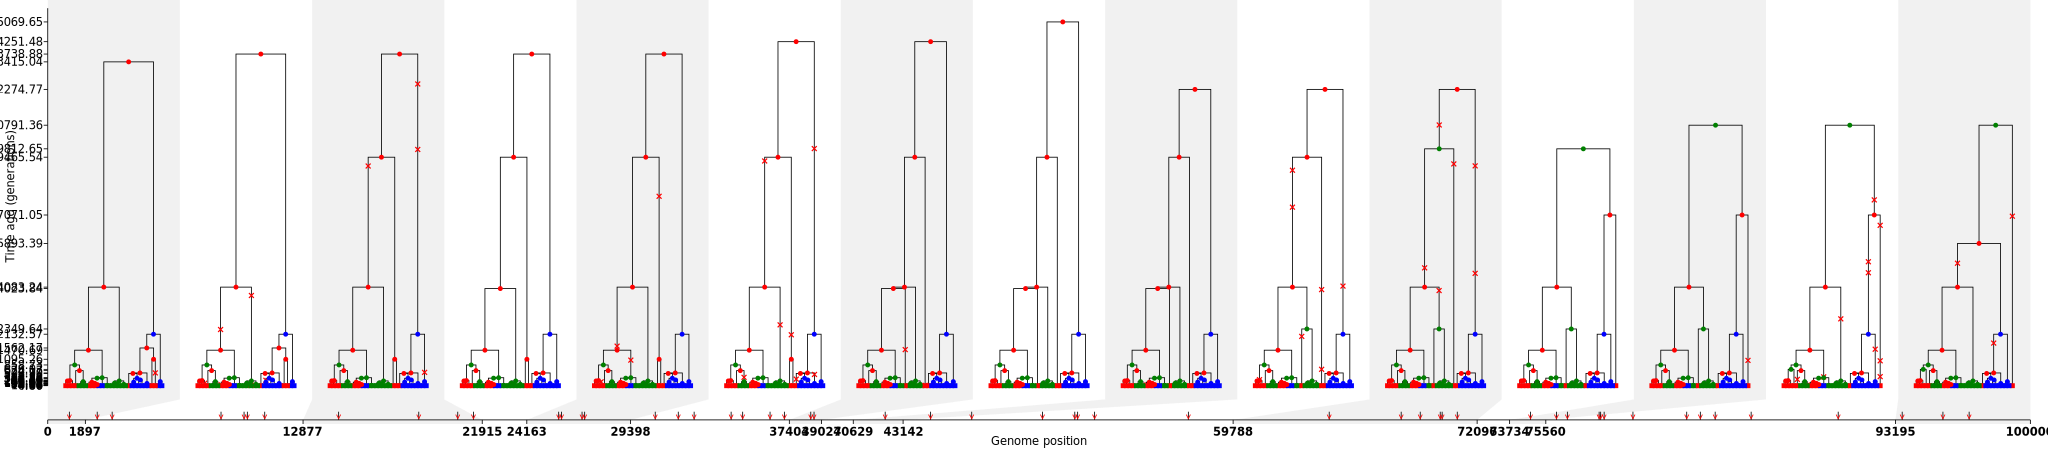

In [11]:
styles = []
# style for each population
for colour, p in zip(['red', 'green', 'blue'], ts.populations()):
    # target the symbols only (class "sym")
    s = f".node.p{p.id} > .sym " + "{" + f"fill: {colour}" + "}"
    styles.append(s)
    #print(f'"{s}" applies to nodes from population {p.metadata["name"]} (id {p.id})')
css_string = " ".join(styles)
#print(f'CSS string applied:\n    "{css_string}"')

ts.draw_svg(
    size=(2500, 550),
    node_labels={},    # Remove all node labels for a clearer viz
    style=css_string,  # Apply the stylesheet
    mutation_labels = {},
    y_axis = True
)

In [12]:
colours = {"pop_0": "red", "pop_1": "green", "pop_2": "blue"}
colours_for_node = {}
for n in ts.samples():
    population_data = ts.population(ts.node(n).population)
    colours_for_node[n] = colours[population_data.metadata["name"]]

individual_for_node = {}
for n in ts.samples():
    individual_data = ts.individual(ts.node(n).individual)
    individual_for_node[n] = individual_data.id

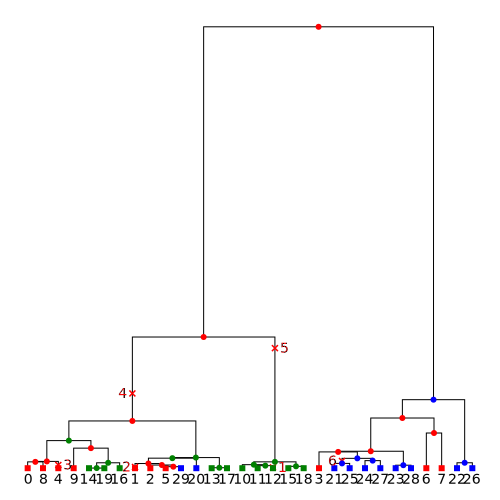

In [13]:
# clear geographic structure here 

ts.at_index(1).draw_svg(#node_colours=colours_for_node, 
    style=css_string,
    node_labels=individual_for_node,
    size=(500, 500)
)

In [14]:
# Plot with tips labeled by population

# tip_lab = {u: f"{u}:p{ts.node(u).population}" for u in ts.samples()}
# ts.at_index(1).draw_svg(node_labels=tip_lab, style=css_string, size = (1500,500))


## function for finding location of mrca for every pair of tips in every tree 

In [15]:
def get_locations_df(ts, samples, trim_flanks = True): 
    type = "inf" 
    if trim_flanks == False:
        type = "sim"
    
    rows = []
    start = 1 if (trim_flanks and ts.num_trees > 2) else 0
    end   = ts.num_trees - 1 if (trim_flanks and ts.num_trees > 2) else ts.num_trees
    for i in range(start, end):
        t = ts.at_index(i)
        L, R = t.interval

        for a, b in combinations(samples, 2):
            u = t.mrca(a, b)
            pop = ts.population(ts.node(u).population).metadata["name"]
            rows.append({
                "index": i, 
                "sample_a": a, 
                "sample_b": b,
                "left": L, 
                "right": R,
                "mrca_population": pop, 
                "type": type,
                "node": u
            })
    return pd.DataFrame(rows)

In [16]:
loc_df = get_locations_df(ts, samples, trim_flanks = False)
loc_df

,index,sample_a,sample_b,left,right,mrca_population,type,node
0,0,0,1,0.0,1897.0,pop_0,sim,55
1,0,0,2,0.0,1897.0,pop_0,sim,55
2,0,0,3,0.0,1897.0,pop_0,sim,67
3,0,0,4,0.0,1897.0,pop_0,sim,44
4,0,0,5,0.0,1897.0,pop_0,sim,55
...,...,...,...,...,...,...,...,...
6520,14,26,28,93195.0,100000.0,pop_2,sim,57
6521,14,26,29,93195.0,100000.0,pop_0,sim,61
6522,14,27,28,93195.0,100000.0,pop_0,sim,50
6523,14,27,29,93195.0,100000.0,pop_0,sim,61


## binning 

In [17]:
def make_edges(L, bin_size):
    return np.arange(0, int(L) + bin_size, bin_size, dtype=np.int64)

def add_bins(df, positions):
    out = []
    
    for i, pos in enumerate(positions):
        mask = (df["left"] <= pos) & (pos < df["right"])   # half-open [left, right) like tskit intervals
        if mask.any():
            tmp = df.loc[mask].copy()
            tmp["bin"] = i
            tmp["position"] = int(pos)
            out.append(tmp)
            
    return pd.concat(out, ignore_index=True)

In [18]:
positions = make_edges(1e5, 1e4)
loc_binned = add_bins(loc_df, positions)
loc_binned

,index,sample_a,sample_b,left,right,mrca_population,type,node,bin,position
0,0,0,1,0.0,1897.0,pop_0,sim,55,0,0
1,0,0,2,0.0,1897.0,pop_0,sim,55,0,0
2,0,0,3,0.0,1897.0,pop_0,sim,67,0,0
3,0,0,4,0.0,1897.0,pop_0,sim,44,0,0
4,0,0,5,0.0,1897.0,pop_0,sim,55,0,0
...,...,...,...,...,...,...,...,...,...,...
4345,13,26,28,75560.0,93195.0,pop_2,sim,57,9,90000
4346,13,26,29,75560.0,93195.0,pop_1,sim,65,9,90000
4347,13,27,28,75560.0,93195.0,pop_0,sim,50,9,90000
4348,13,27,29,75560.0,93195.0,pop_1,sim,65,9,90000


In [19]:
#loc_binned.to_csv('locations_df.csv', index=False)

### locations for a given pair aren't consistent! 
i.e. we can see local variation across the tree sequence

In [20]:
counts = pd.DataFrame(loc_df.groupby(['sample_a', 'sample_b', 'mrca_population'])['mrca_population'].count())
counts

mrca_population
sample_a sample_b mrca_population                 
0        1        pop_0                         15
         2        pop_0                         15
         3        pop_0                         12
                  pop_1                          3
         4        pop_0                         15
...                                            ...
27       28       pop_0                         15
         29       pop_0                         12
                  pop_1                          3
28       29       pop_0                         12
                  pop_1                          3

[660 rows x 1 columns]

In [21]:
# visualize location counts where sample a = 0
counts['mrca_population'][26]

sample_b  mrca_population
27        pop_2              15
28        pop_2              15
29        pop_0              12
          pop_1               3
Name: mrca_population, dtype: int64

### export trees for gaia 

In [22]:
# 27 01 2026
#ts.dump("demo.trees")

# array([[0.    , 0.    , 0.    ],
#        [0.0003, 0.    , 0.0001],
#        [0.0003, 0.0001, 0.    ]])

In [23]:
# 30 01 2026
# ts.dump("demo.trees")

# array([[0.    , 0.0001, 0.0001],
#        [0.0006, 0.    , 0.0002],
#        [0.0006, 0.0002, 0.    ]])

# infer tree sequence

#### define insert_proxy_samples

In [24]:
import logging
logger = logging.getLogger("tsinfer")

def insert_proxy_samples(
        self,
        variant_data,
        *,
        sample_ids=None,
        epsilon=None,
        keep_ancestor_times=None,
        allow_mutation=None,  # deprecated alias
        **kwargs,
):
        """
        Take a set of samples from a :class:`.VariantData` instance and create additional
        "proxy sample ancestors" from them, returning a new :class:`.AncestorData`
        instance including both the current ancestors and the additional ancestors
        at the appropriate time points.

        A *proxy sample ancestor* is an ancestor based upon a known sample. At
        sites used in the full inference process, the haplotype of this ancestor
        is identical to that of the sample on which it is based. The time of the
        ancestor is taken to be a fraction ``epsilon`` older than the sample on
        which it is based.

        A common use of this function is to provide ancestral nodes for anchoring
        historical samples at the correct time when matching them into a tree
        sequence during the :func:`tsinfer.match_samples` stage of inference.
        For this reason, by default, the samples chosen from ``sample_data``
        are those associated with historical (i.e. non-contemporary)
        :ref:`individuals <sec_inference_data_model_individual>`. This can be
        altered by using the ``sample_ids`` parameter.

        .. note::

            The proxy sample ancestors inserted here will correspond to extra nodes
            in the inferred tree sequence. At sites which are not used in the full
            inference process (e.g. sites unique to a single historical sample),
            these proxy sample ancestor nodes may have a different genotype from
            their corresponding sample.

        :param VariantData variant_data: The `VariantData` instance
            from which to select the samples used to create extra ancestors.
        :param list(int) sample_ids: A list of sample ids in the ``variant_data``
            instance that will be selected to create the extra ancestors. If
            ``None`` (default) select all the historical samples, i.e. those
            associated with an :ref:`sec_inference_data_model_individual` whose
            time is greater than zero. The order of ids is ignored, as are
            duplicate ids.
        :param list(float) epsilon: An list of small time increments
            determining how much older each proxy sample ancestor is than the
            corresponding sample listed in ``sample_ids``. A single value is also
            allowed, in which case it is used as the time increment for all selected
            proxy sample ancestors. If None (default) find :math:`{\\delta}t`, the
            smallest time difference between the sample times and the next
            oldest ancestor in the current :class:`.AncestorData` instance, setting
            ``epsilon`` = :math:`{\\delta}t / 100` (or, if all selected samples
            are at least as old as the oldest ancestor, take :math:`{\\delta}t`
            to be the smallest non-zero time difference between existing ancestors).
        :param bool keep_ancestor_times: If ``False`` (the default), the existing
            times of the ancestors in the current :class:`.AncestorData` instance
            may be increased so that derived states in the inserted proxy samples.
            can have an ancestor with a mutation to that site above them (i.e. the
            infinite sites assumption is maintained). This is useful when sites
            times have been approximated by using their frequency. Alternatively,
            if ``keep_ancestor_times`` is ``True``, existing ancestor times are
            preserved, and inserted proxy sample ancestors are allowed to
            possess derived alleles at sites where there are no pre-existing
            mutations in older ancestors. This can lead to a de-novo mutation at a
            site that also has a mutation elsewhere (i.e. breaking the infinite sites
            assumption).
        :param bool allow_mutation: Deprecated alias for `keep_ancestor_times`.
        :param \\**kwargs: Further arguments passed to the constructor when creating
            the new :class:`AncestorData` instance which will be returned.

        :return: A new :class:`.AncestorData` object.
        :rtype: AncestorData
        """
        if allow_mutation is not None:
            if keep_ancestor_times is not None:
                raise ValueError(
                    "Cannot specify both `allow_mutation` and `keep_ancestor_times`"
                )
            keep_ancestor_times = allow_mutation
        self._check_finalised()
        variant_data._check_finalised()
        if self.sequence_length != variant_data.sequence_length:
            raise ValueError("variant_data does not have the correct sequence length")
        used_sites = np.isin(variant_data.sites_position[:], self.sites_position[:])
        if np.sum(used_sites) != self.num_sites:
            raise ValueError("Genome positions in ancestors missing from variant_data")

        if sample_ids is None:
            sample_ids = []
            for i in variant_data.individuals():
                if i.time > 0:
                    sample_ids += i.samples
        # sort by ID and make unique for quick haplotype access
        sample_ids, unique_indices = np.unique(np.array(sample_ids), return_index=True)

        sample_times = np.zeros(len(sample_ids), dtype=self.ancestors_time.dtype)
        for i, s in enumerate(sample_ids):
            sample = variant_data.sample(s)
            if sample.individual != tskit.NULL:
                sample_times[i] = variant_data.individual(sample.individual).time

        if epsilon is not None:
            epsilons = np.atleast_1d(epsilon)
            if len(epsilons) == 1:
                # all get the same epsilon
                epsilons = np.repeat(epsilons, len(sample_ids))
            else:
                if len(epsilons) != len(unique_indices):
                    raise ValueError(
                        "The number of epsilon values must equal the number of "
                        f"sample_ids ({len(sample_ids)})"
                    )
                epsilons = epsilons[unique_indices]

        else:
            anc_times = self.ancestors_time[:][::-1]  # find ascending time order
            older_index = np.searchsorted(anc_times, sample_times, side="right")
            # Don't include times older than the oldest ancestor
            allowed = older_index < self.num_ancestors
            if np.sum(allowed) > 0:
                delta_t = anc_times[older_index[allowed]] - sample_times[allowed]
            else:
                # All samples have times equal to or older than the oldest curr ancestor
                time_diffs = np.diff(anc_times)
                delta_t = np.min(time_diffs[time_diffs > 0])
            epsilons = np.repeat(np.min(delta_t) / 100.0, len(sample_ids))

        proxy_times = sample_times + epsilons
        time_sorted_indexes = np.argsort(proxy_times)
        reverse_time_sorted_indexes = time_sorted_indexes[::-1]
        # In cases where we have more than a handful of samples to use as proxies, it is
        # inefficient to access the haplotypes out of order, so we iterate and cache
        # (caution: the haplotypes list may be quite large in this case)
        haplotypes = [
            h[1] for h in variant_data.haplotypes(
                samples=sample_ids, sites=used_sites, recode_ancestral=True
            )
        ]

        new_anc_times = self.ancestors_time[:]  # this is a copy
        if not keep_ancestor_times:
            assert np.all(np.diff(self.ancestors_time) <= 0)
            # Find the youngest (max) ancestor ID constrained by each sample haplotype
            site_ancestor = -np.ones(self.num_sites, dtype=int)
            anc_min_time = np.zeros(self.num_ancestors, dtype=self.ancestors_time.dtype)
            # If (unusually) there are multiple ancestors for the same focal site, we
            # can take the youngest
            for ancestor_id, focal_sites in enumerate(self.ancestors_focal_sites):
                site_ancestor[focal_sites] = ancestor_id
            for hap_id in time_sorted_indexes:
                derived_sites = haplotypes[hap_id] > 0
                if np.sum(derived_sites) == 0:
                    root = 0  # no derived sites, so only needs to be below the root
                    for i, focal_sites in enumerate(self.ancestors_focal_sites):
                        if len(focal_sites) > 0:
                            if i > 0:
                                root = i - 1
                            anc_min_time[root] = proxy_times[hap_id] + epsilons[hap_id]
                            break
                else:
                    max_anc_id = np.max(site_ancestor[derived_sites])  # youngest ancstr
                    if max_anc_id >= 0:
                        anc_min_time[max_anc_id] = proxy_times[hap_id] + epsilons[hap_id]
            # Go from youngest to oldest, pushing up the times of the ancestors to
            # achieve compatibility with infinite sites.
            # TODO - replace with something mre efficient that uses time_diffs
            for anc_id in range(self.num_ancestors - 1, -1, -1):
                current_time = new_anc_times[anc_id]
                if anc_min_time[anc_id] > current_time:
                    new_anc_times[:(anc_id + 1)] += anc_min_time[anc_id] - current_time
            assert new_anc_times[1] > np.max(sample_times)  # root ancestor

        with self.__class__(  # Create new AncestorData instance to return
            variant_data.sites_position[:][used_sites],
            variant_data.sequence_length,
            **kwargs,
        ) as other:
            mutated_sites = set()  # To check if mutations have occurred yet
            ancestors_iter = self.ancestors()
            anc = next(ancestors_iter, None)
            for i in reverse_time_sorted_indexes:
                proxy_time = proxy_times[i]
                sample_id = sample_ids[i]
                haplotype = haplotypes[i]
                derived_sites = set(np.where(haplotype > 0)[0])
                while anc is not None and new_anc_times[anc.id] > proxy_time:
                    anc_time = new_anc_times[anc.id]
                    other.add_ancestor(
                        anc.start, anc.end, anc_time, anc.focal_sites, anc.haplotype)
                    mutated_sites.update(anc.focal_sites)
                    anc = next(ancestors_iter, None)
                if not derived_sites.issubset(mutated_sites):
                    assert not keep_ancestor_times
                    logging.info(
                        f"Infinite sites assumption deliberately broken: {sample_id}"
                        "contains an allele which requires a novel mutation."
                    )
                logger.debug(
                    f"Inserting proxy ancestor: sample {sample_id} at time {proxy_time}"
                )
                other.add_ancestor(
                    start=0,
                    end=self.num_sites,
                    time=proxy_time,
                    focal_sites=[],
                    haplotype=haplotype,
                )
            # Add any ancestors remaining in the current instance
            while anc is not None:
                anc_time = new_anc_times[anc.id]
                other.add_ancestor(
                    anc.start, anc.end, anc_time, anc.focal_sites, anc.haplotype,  
                )
                anc = next(ancestors_iter, None)

            other.clear_provenances()
            for timestamp, record in self.provenances():
                other.add_provenance(timestamp, record)
            other.record_provenance(command="insert_proxy_samples", **kwargs)

        assert other.num_ancestors == self.num_ancestors + len(sample_ids)
        return other

# export/import simulated ts

# run inference

bin etc

In [ ]:
# export again

# future

## binning ... 

In [ ]:
# insert function for binning tree sequence and re-identifying mrca locations

## validation: proportion of correctly labeled mrca locations 

In [ ]:
# insert functions for inferring/dating tree sequence

In [266]:
# insert function for comparing inferred mrca_locations to truth